In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model, multi_gpu_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask, CapsCNN
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.cifar import dataGenerator

Using TensorFlow backend.


In [2]:
# Plotting for dark theme
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Parameters

In [3]:
num_class = 10
input_shape = (32, 32, 3)
m_train = 50000
m_test = 10000

batch_size = 16

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [4]:
trainGenerator = dataGenerator('train', batch_size=batch_size, reshape=False, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False)

# Model

In [5]:
model = Sequential([
    Convolution2D(filters=256, kernel_size=(9, 9), strides=1, padding='valid', activation='relu', input_shape=input_shape),
    PrimaryCaps(capsules=32, capsule_dim=8, kernel_size=(9, 9), strides=2, padding="valid", activation_caps=squash),
    Caps(capsules=num_class, capsule_dim=16, routings=3, activation_caps=squash),
    ClassesCaps(name='capsule'),
])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 256)       62464     
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 2048, 8)           5308672   
_________________________________________________________________
caps_1 (Caps)                (None, 10, 16)            2621440   
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total params: 7,992,576
Trainable params: 7,992,576
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
model.compile(optimizer=Adam(lr=3e-4),
              loss=margin(),
              metrics={'capsule': 'categorical_accuracy'})

In [8]:
hist = model.fit_generator(trainGenerator,
                           steps_per_epoch=trainGenerator.n // trainGenerator.batch_size,
                           epochs=5,
                           validation_data=testGenerator,
                           validation_steps=testGenerator.n // testGenerator.batch_size,
                           workers=4,
                           verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
3125/3125 [==============================] - 431s 138ms/step - loss: 0.4077 - categorical_accuracy: 0.3906 - val_loss: 0.3703 - val_categorical_accuracy: 0.4611
Epoch 2/5
3125/3125 [==============================] - 427s 137ms/step - loss: 0.3551 - categorical_accuracy: 0.4935 - val_loss: 0.3336 - val_categorical_accuracy: 0.5280
Epoch 3/5
3125/3125 [==============================] - 427s 137ms/step - loss: 0.3314 - categorical_accuracy: 0.5370 - val_loss: 0.3177 - val_categorical_accuracy: 0.5573
Epoch 4/5
3125/3125 [==============================] - 426s 136ms/step - loss: 0.3152 - categorical_accuracy: 0.5657 - val_loss: 0.3119 - val_categorical_accuracy: 0.5759
Epoch 5/5
3125/3125 [==============================] - 426s 136ms/step - loss: 0.3017 - categorical_accuracy: 0.5915 - val_loss: 0.3003 - val_categorical_accuracy: 0.5957


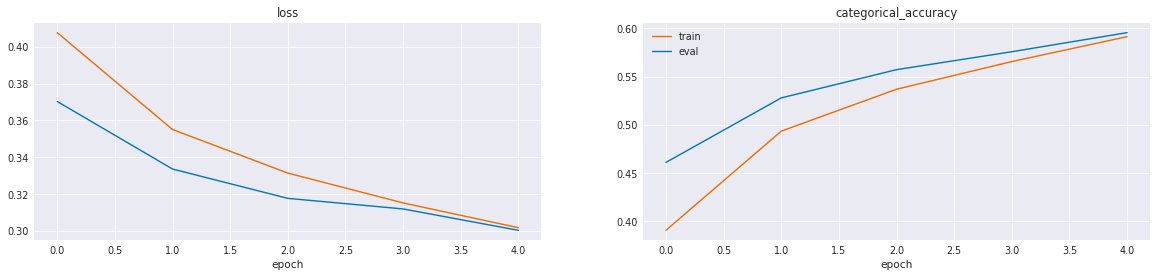

In [9]:
plotHistory(hist.history)
plt.savefig('cifar_history.png')